# Timeseries Plotting

__Description & purpose__: This Notebook is designed to demonstrate how to plot a timeseries using data held on the Earth Observation Data Hub. This notebook plots data for a point in Greater London. It is assumed that the notebook will be running within the Notebook Service on the Hub. 

The first thing to do is ensure that the most recent version of `pyeodh` is installed on your system. It is good practice to run the following cell if you have not installed `pyeodh` or have not used it in a while. The cell will also install the plotting and spatial libraries required.

In [ ]:
# Run this cell if pyeodh is not installed, or needs updating
!pip install --upgrade pyeodh
!pip install hvplot shapely ipywidgets rasterio pyproj

# Exploring the Resource Catalogue

Now we are ready to investigate the Resource Catalogue. First off, we need to import the packages we'll use.

In [2]:
# Import the Python API Client
import pyeodh

# Import all other packages
import math
import shapely 
import rasterio

import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
from pyproj import Transformer

import urllib.request
from PIL import Image
from io import BytesIO

from IPython.display import display
from ipywidgets import interact

Next we need to create an instance of the `Client`, which is our entrypoint to EODH APIs. From there we can start to search the collections held within the platform.

In [ ]:
# Connect to the Hub
# base_url can be changed to optionally specify a different server, but the default is the production server

client = pyeodh.Client(
    base_url="https://eodatahub.org.uk"
).get_catalog_service()


# Print a list of the collections held in the Resource Catalogue (their id and description).
# As the Resource Catalogue fills and development continues, the number of collections and the richness of their descriptions will increase
for index, collect in enumerate(client.get_collections(), start=1):
    print(f"{index} -- {collect.id}")
    print(f"{collect.description}")

_Note_: for clarity the output from this command is not being shown here. Expect a long scrollable list. 

The attributes of a catalogue are mapped to a series of properties. For instance, in the following cell we print the `id`, `title` and `description`.

In [4]:
# The next thing to do is find some open data

# Let's use the CEDA Sentinel 2 ARD
s2ard_cat = client.get_catalog("public/catalogs/ceda-stac-catalogue").get_collection('sentinel2_ard')

print("id: ", s2ard_cat.id)
print("title: ", s2ard_cat.title)
print("description: ", s2ard_cat.description)

id:  sentinel2_ard
title:  Sentinel 2 ARD
description:  These data have been created by the Department for Environment, Food and Rural Affairs (Defra) and Joint Nature Conservation Committee (JNCC) in order to cost-effectively provide high quality, Analysis Ready Data (ARD) for a wide range of applications. The dataset contains modified Copernicus Sentinel-2 (Level 1C data processed into a surface reflectance product using ARCSI software (Level 2)).


The Hub API endpoints are wrapped in methods inside `pyeodh` and are structured into classes, following the same logic as the underlying APIs. This means that, for example, to fetch a collection item we first need to get the collection from the resource catalogue. The following cell provedes a code example to do this. 

In [5]:
s2ard = client.get_catalog("public/catalogs/ceda-stac-catalogue").get_collection('sentinel2_ard')
s2ard

Some API responses are paginated (e.g. collection items), and you can simply iterate over them.

In [6]:
items = s2ard.get_items()

# Warning: without the limit to 10 items this will take a long time for large catalogues such as s2ard
for item in items[:10]:
    print(item.id)

neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn590lonw0063_T29VPF_ORB023_20251130142106_utm29n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn590lonw0055_T30VUL_ORB023_20251130142106_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn590lonw0038_T30VVL_ORB023_20251130142106_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn581lonw0064_T29VPE_ORB023_20251130142106_utm29n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn581lonw0055_T30VUK_ORB023_20251130142106_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn581lonw0038_T30VVK_ORB023_20251130142106_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn572lonw0064_T29VPD_ORB023_20251130142106_utm29n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn572lonw0054_T30VUJ_ORB023_20251130142106_utm30n_osgb
neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn563lonw00

Now we want to access the first few items and see what they are called and how much cloud there is. 

In [7]:
for i, item in enumerate(items[:10]):
    print(i, " ", item.id)
    print("Cloud cover: ", item.properties['eo:cloud_cover']) 

0   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn590lonw0063_T29VPF_ORB023_20251130142106_utm29n_osgb
Cloud cover:  42.67
1   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn590lonw0055_T30VUL_ORB023_20251130142106_utm30n_osgb
Cloud cover:  55.48
2   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn590lonw0038_T30VVL_ORB023_20251130142106_utm30n_osgb
Cloud cover:  31.54
3   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn581lonw0064_T29VPE_ORB023_20251130142106_utm29n_osgb
Cloud cover:  26.12
4   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn581lonw0055_T30VUK_ORB023_20251130142106_utm30n_osgb
Cloud cover:  16.69
5   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn581lonw0038_T30VVK_ORB023_20251130142106_utm30n_osgb
Cloud cover:  13.24
6   neodc.sentinel_ard.data.sentinel_2.2025.11.30.S2A_20251130_latn572lonw0064_T29VPD_ORB023_20251130142106_utm29n_osgb
Cloud cover:  50.0
7   neodc.sentinel_ar

To find specific imagery for a given date range we can set up a search with a query. That query needs to have a start and end date. 

If we wanted a specific location, we could add in an `intersects` parameter.

In [8]:

items = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["public/catalogs/ceda-stac-catalogue"],
    query=[
        'start_datetime>=2024-04-01',
        'end_datetime<=2024-09-30', 
    ],
)

# We can then count the number of items returned by the search 

total_items = sum(1 for _ in items)
print(f"Total items: {total_items}")


Total items: 3412


For this example we will use a location that relates to the WWT London Wetlands Centre: https://www.wwt.org.uk/wetland-centres/london

In [9]:
# Define the WWT site
lon, lat = (-0.2346089199955088, 51.478446832015834)
wwt_pnt = shapely.Point(lon, lat) 


items = client.search(
    collections=['sentinel2_ard'],
    catalog_paths=["public/catalogs/ceda-stac-catalogue"],
    intersects = wwt_pnt,
    query=[
        'start_datetime>=2024-04-01',
        'end_datetime<=2024-09-30',
        'eo:cloud_cover<=30',
    ],
)

# We can then count the number of items returned by the search 

total_items = sum(1 for _ in items)
print(f"Total items: {total_items}")

Total items: 13



A useful thing to do now is find the asset information for one of those items. We shall use the first item in the list. 

In [10]:
for item in items[:1]:  # Process only the first item
    print(f"Item ID: {item.id}")
    print("Assets:")
    
    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            print(f"  - {asset_key}: {asset.to_dict()}")  # Convert asset to dict for readable output
            print("-" * 40)  # Separator for better readability

Item ID: neodc.sentinel_ard.data.sentinel_2.2024.09.19.S2A_20240919_latn518lonw0008_T30UXC_ORB094_20240919144023_utm30n_osgb
Assets:
  - cloud: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2024/09/19/S2A_20240919_latn518lonw0008_T30UXC_ORB094_20240919144023_utm30n_osgb_clouds.tif', 'type': 'image/tiff; application=geotiff', 'size': 2116177, 'location': 'on_disk', 'roles': ['data']}
----------------------------------------
  - cloud_probability: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2024/09/19/S2A_20240919_latn518lonw0008_T30UXC_ORB094_20240919144023_utm30n_osgb_clouds_prob.tif', 'type': 'image/tiff; application=geotiff', 'size': 31613463, 'location': 'on_disk', 'roles': ['data']}
----------------------------------------
  - cog: {'href': 'https://dap.ceda.ac.uk/neodc/sentinel_ard/data/sentinel_2/2024/09/19/S2A_20240919_latn518lonw0008_T30UXC_ORB094_20240919144023_utm30n_osgb_vmsk_sharp_rad_srefdem_stdsref.tif', 'type': 'image/tiff; a

We can see that this returns a lot of information. We can extract the thumbnail URL and use that to plot the image overview.

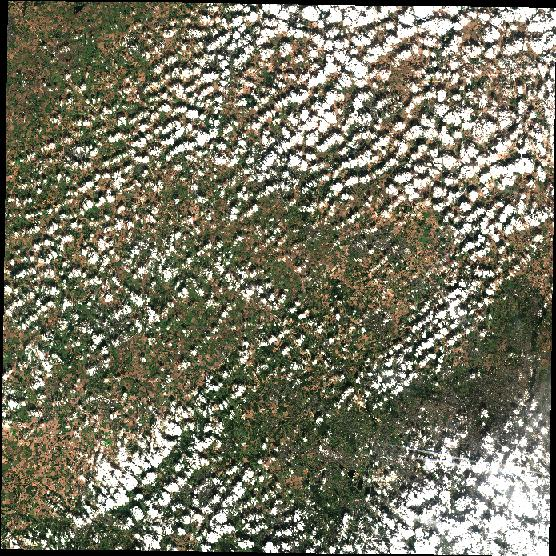

In [11]:
tn_url = None

for item in items[:2]:  # Process only the second item
    
    if not item.assets:
        print("  No assets available.")
    else:
        for asset_key, asset in item.assets.items():
            if asset_key == "thumbnail":
                tn_url = asset.href  # Directly access the href attribute
    
# Here we open the remote URL, read the data and dislay the thumbnail 
with urllib.request.urlopen(tn_url) as url:
    img = Image.open(BytesIO(url.read()))

display(img)

In [12]:
# code to show all thumbnails

thumbnail_urls = []

for item in items:
    if not item.assets:
        continue
    if "thumbnail" in item.assets:
        thumbnail_urls.append(item.assets["thumbnail"].href) # collect link to thumbnails

print(f"Number of assets with thumbnails: {len(thumbnail_urls)}")

# Ask for start and end thumbnails
start = int(input("Start image: "))
end   = int(input("End image: "))

# Clamp the range
start = max(0, start)
end   = min(len(thumbnail_urls), end)

selected_urls = thumbnail_urls[start:end]

print(f"Showing thumbnails {start} to {end-1}")

images = []
for url in selected_urls:
    with urllib.request.urlopen(url) as u:
        img = Image.open(BytesIO(u.read())) # get the thumbnails
        images.append(img)

# Determine grid size (roughly square)
cols = 5
rows = math.ceil(len(images) / cols)

Number of assets with thumbnails: 13


Start image:  1
End image:  6


Showing thumbnails 1 to 5


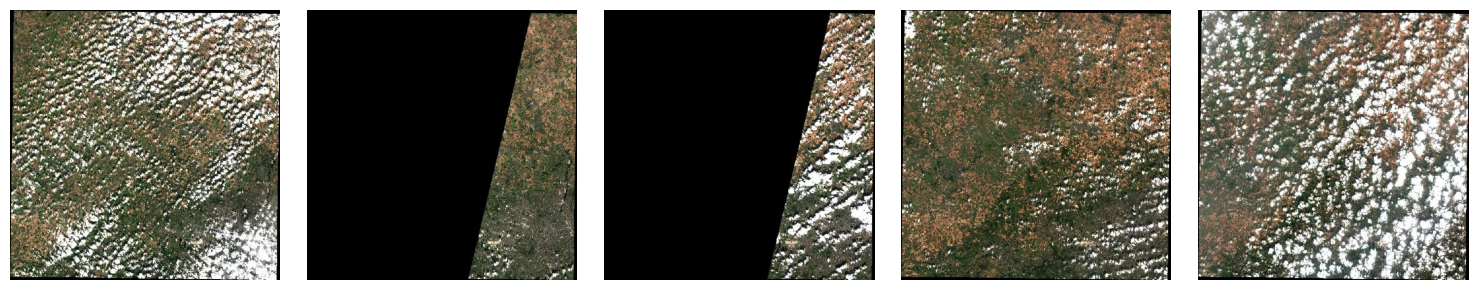

In [13]:
# Plot thumbnail matrix
fig = plt.figure(figsize=(15, 3 * rows))

for i, img in enumerate(images):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Timeseries


In [16]:
# EPSG:4326 → EPSG:27700
transformer = Transformer.from_crs("EPSG:4326", "EPSG:27700", always_xy=True)
xc, yc = transformer.transform(lon, lat)


dates, ndwi_vals = [], []

# Extract NDWI for each scene 
for item in items:

    asset = item.assets["cog"]
    href = asset.href

    # Extract band ordering from eo:bands list
    bands = asset.extra_fields["eo:bands"]
    band_index = {b["name"]: i + 1 for i, b in enumerate(bands)}

    # Need B03 (green) and B08 (nir)
    g_idx = band_index["B03"]
    n_idx = band_index["B08"]

    # Sample the COG
    try:
        with rasterio.open(href) as src:
            green = list(src.sample([(xc, yc)], indexes=g_idx))[0][0]
            nir   = list(src.sample([(xc, yc)], indexes=n_idx))[0][0]
    except:
        continue

    # Skip invalid values
    if green <= 0 or nir <= 0:
        continue

    ndwi = (((green/100) - (nir/100)) / ((green/100) + (nir/100))) # Working on the reasoning that the data needs rescaling by 100 

    # Store result
    dates.append(item.datetime)
    ndwi_vals.append(float(ndwi))


Finally we plot the data using `hvplot` which allows the user to interact with the chart.

In [17]:
df = pd.DataFrame({
    "date": dates,
    "ndwi": ndwi_vals
})

df.hvplot.line(
    x="date",
    y="ndwi",
    title="NDWI Timeseries at WWT London",
    ylabel="NDWI",
    xlabel="Date",
    marker="o",
    grid=True,
    width=700,
    height=350,
)

:Curve   [date]   (ndwi)